# ------------ TIM Python Client - System Driven Anomaly Detection ------------

# 0. Setup

In [16]:
import pandas as pd
import json
import datetime as dt
import numpy as np
import plotly as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as splt

In [17]:
import tim
tim_credentials = json.load(open('tim_credentials.json'))
client = tim.Tim(email=tim_credentials['email'],password=tim_credentials['password'])

# 1. Data Preparation

In [50]:
csv_df = pd.read_csv('gearbox.csv')

In [61]:
tim_dataset = csv_df.copy()
timestamp = 'timestamp'
predictors = [s for s in list(tim_dataset.columns) if s not in [timestamp]]
tim_dataset[timestamp] = pd.to_datetime(tim_dataset[timestamp],format='%Y-%m-%dT%H:%M:%SZ')

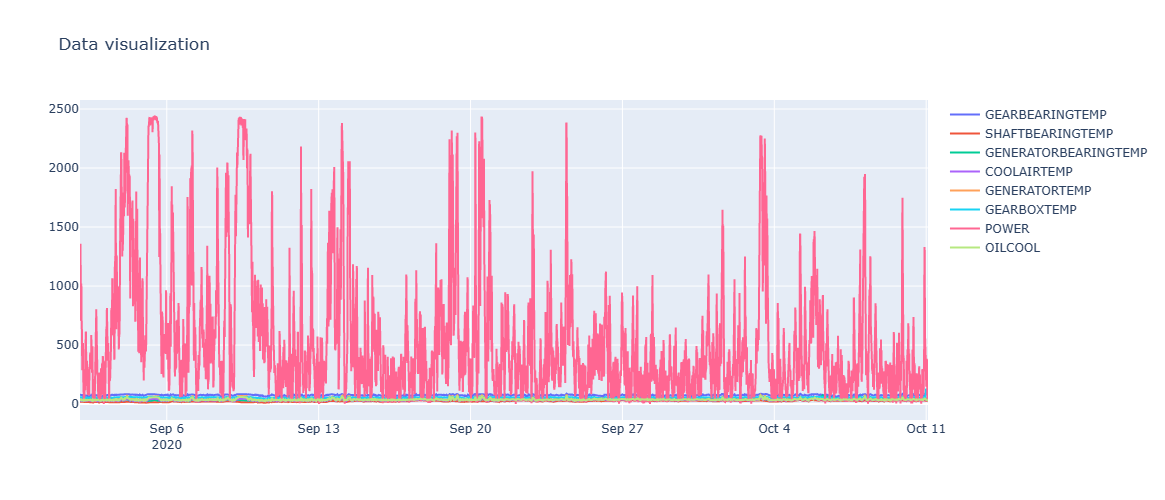

In [62]:
v_data = tim_dataset.copy()
fig = splt.make_subplots(rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.02)
for idx, p in enumerate(predictors):
    fig.add_trace(go.Scatter(x=v_data[timestamp], y=v_data[p], name=p), row=1, col=1)
fig.update_layout(height=500, width=1200, title_text="Data visualization")
fig.show()    

# 2. TIM

## 2.1 Workflow

In [63]:
# -----------------------------------------------------------------------------------------------------
upload_dataset_configuration = {
    "name": "system_driven_dataset",
}
tim_upload_dataset = client.upload_dataset(
    dataset = tim_dataset,
    configuration = upload_dataset_configuration,
    outputs = ['response'],
    status_poll = print
)
upload_dataset_response = tim_upload_dataset.response
dataset_id = upload_dataset_response['id']
# ---------------------------------------------------------------------------------------------------------------------------------
create_use_case_configuration = {
    "name": "system_driven_anomaly_detection",
    "dataset": {"id":dataset_id}
}
tim_use_case = client.use_cases.create_use_case(configuration=create_use_case_configuration)
use_case_id = tim_use_case['id']
# ---------------------------------------------------------------------------------------------------------------------------------
create_experiment_configuration = {
    "name": "system_driven_anomaly_detection",
    "useCase": {"id": use_case_id},
    "type": 'AnomalyDetection'
}
tim_experiment = client.experiments.create_experiment(configuration=create_experiment_configuration)
experiment_id = tim_experiment['id']
# ---------------------------------------------------------------------------------------------------------------------------------

{'status': 'Running', 'progress': 0.0, 'createdAt': '2023-02-06T13:21:08.527Z'}
{'status': 'Finished', 'progress': 100.0, 'createdAt': '2023-02-06T13:21:08.527Z'}


## 2.2 Configuration

In [67]:
detection_build_system_model_configuration = {
    # "name": "My first anomaly build-model job",
    "useCase": {"id": use_case_id},
    "experiment": {"id": experiment_id},
    # "configuration": {
        # "domainSpecifics": {
            # "sensitivity": 1,
            # "minSensitivity": 0,
            # "maxSensitivity": 0,
            # "anomalyIndicatorWindow": {"baseUnit": "Sample","value": 10}
        # },
        # "model": {
        #     "numberOfTrees": 150,
        #     "subSampleSize": 512,
        #     "maxTreeDepth": 10,
        #     "extensionLevel": 1,
        #     "normalization": True
        # }
    # },
    "data": {
        # "version": {"id": "a74ae716-a86e-47f0-8a50-d8b21d6d7dd6"},
        # "rows": {"type":"Last","baseUnit": "Sample","value": 1}, # or [{"from": "yyyy-mm-dd HH:MM:SS","to": "yyyy-mm-dd HH:MM:SS"}]
        "columns": predictors,
        # "labelColumn": target,
        # "imputation": {"type": "LOCF","maxGapLength": 6},
        # "timeScale": {"baseUnit": "Hour","value": 1}
    }
}
detection_build_system_model_configuration

{'useCase': {'id': '984d7a30-882c-4ce0-a6c7-eb5046218792'},
 'experiment': {'id': '6ec179ff-1b35-44e5-9b2d-665819f0f8fc'},
 'data': {'columns': ['GEARBEARINGTEMP',
   'SHAFTBEARINGTEMP',
   'GENERATORBEARINGTEMP',
   'COOLAIRTEMP',
   'GENERATORTEMP',
   'GEARBOXTEMP',
   'POWER',
   'OILCOOL']}}

## 2.3 Model Building

In [68]:
# -----------------------------------------------------------------------------------------------------
detection_build_system_model = client.detection_build_system_model(
    configuration = detection_build_system_model_configuration,
    dataset_id = dataset_id,
    execute = True,
    wait_to_finish = True,
    outputs = [
        'id',
        'details',
        'logs',
        'status',
        'table',
        'model',
        'accuracies'
    ],
    status_poll = print,
    tries_left = 300
 )
# -----------------------------------------------------------------------------------------------------
detection_build_system_model_id = detection_build_system_model.id
detection_build_system_model_details = detection_build_system_model.details
detection_build_system_model_logs = detection_build_system_model.logs
detection_build_system_model_status = detection_build_system_model.status
detection_build_system_model_table = detection_build_system_model.table
detection_build_system_model_model = detection_build_system_model.model
detection_build_system_model_accuracies = detection_build_system_model.accuracies

{'status': 'Running', 'createdAt': '2023-02-06T13:22:05.718Z'}
{'status': 'Running', 'progress': 100.0, 'CPU': 0.02, 'memory': 2820.0, 'createdAt': '2023-02-06T13:22:09.987Z'}
{'status': 'Finished', 'progress': 100.0, 'CPU': 0.02, 'memory': 2820.0, 'createdAt': '2023-02-06T13:22:09.987Z'}


# 3. Results

## 3.1 Visual

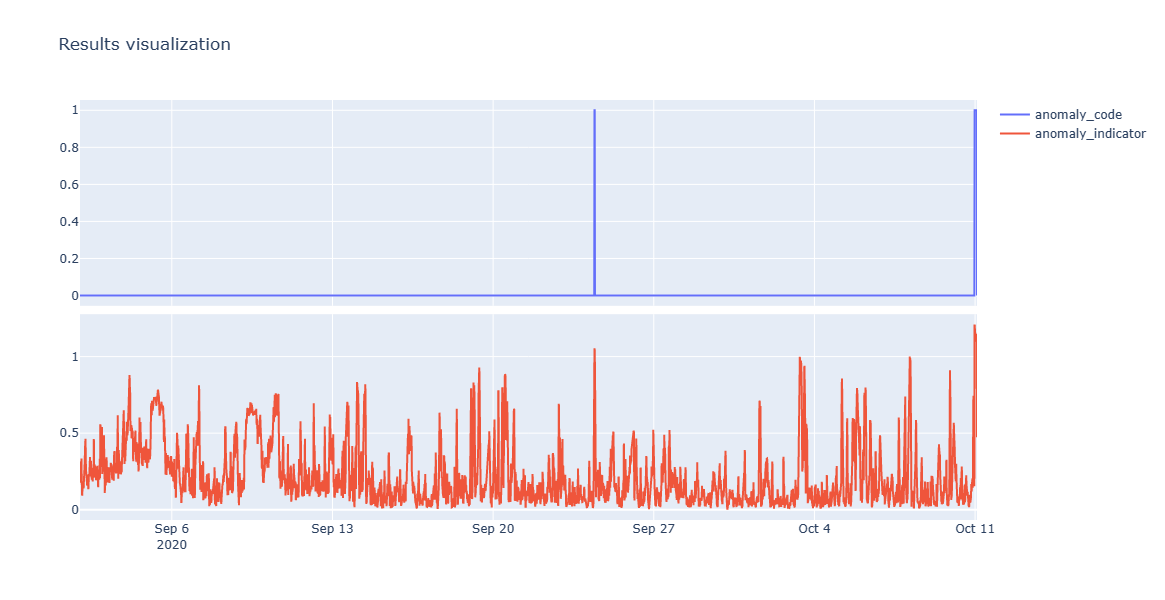

In [69]:
results = detection_build_system_model_table.copy()
fig = splt.make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02)
fig.add_trace(go.Scatter(x=results['timestamp'], y=results['anomaly_code'], name='anomaly_code'), row=1, col=1)
fig.add_trace(go.Scatter(x=results['timestamp'], y=results['anomaly_indicator'], name='anomaly_indicator'), row=2, col=1)
fig.add_hline(x0=results['timestamp'].min(),x1=results['timestamp'].max(),y=1, line_color="orange", row=2, col=1)
fig.update_layout(height=600, width=1200, title_text="Results visualization")
fig.show()    

## 3.2 Anomaly List

In [75]:
anomaly_list_df = detection_build_system_model_table[detection_build_system_model_table['anomaly_code']==1].copy().rename(columns={'anomaly_code':'anomaly'})
anomaly_list_df['timestamp'] = pd.to_datetime(anomaly_list_df['timestamp'],format='%Y-%m-%dT%H:%M:%S.%fZ')
anomaly_list_df

,timestamp,anomaly,anomaly_indicator
2152,2020-09-24 10:00:00,1,1.053816
2153,2020-09-24 10:15:00,1,1.041005
3742,2020-10-10 23:30:00,1,1.209854
3743,2020-10-10 23:45:00,1,1.153977
3744,2020-10-11 00:00:00,1,1.138171
3745,2020-10-11 00:15:00,1,1.137697
3746,2020-10-11 00:30:00,1,1.139483
3747,2020-10-11 00:45:00,1,1.143252
3748,2020-10-11 01:00:00,1,1.148095
3749,2020-10-11 01:15:00,1,1.122138
